## Dynamic Transmission Risk ##

### Structure ###

In [SIR: Factors Influencing Spread](sir.ipynb), we assumed a constant daily rate of transmission risk during the infectious period. This is in keeping with the SIR model, however, in reality we know that transmission risk is influenced by an infected person's viral load, which is a dynamic property.

**RKnot** can incorporate dynamic transmission rate and we will compare its impact to the outcomes of some of the simulations used in SIR. The model and parameters used in this scenario are derived from this paper from the [Fred Hutchinson Cancer Research Center](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf), hence forth known as the Hutch model.

In particular, parameters for the FHUTCH model require:

* average of 4 contacts per day
* variance of 40 contacts$^2$ per day
* The paper notes that these parameters should result in an $R_0$ of 1.8x.

The group structure continues to be informed by [CDC Best Planning Scenario](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html) guidelines for IFR.

Other assumptions:

* Population of 10,000
    * proportionately split among the 4 age groups to match [US Census data](https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf).
* Initial Infected of 2
* Duration of Immunity 365 days
* Density of 1 dot / location (excluding the vbox)
* a collection of 9,142 separate events, each recurring every 30 days.

*See [Sizing](sizing.ipynb#Complex-Environments) for a detailed exercise on building this sim space.*

We will try to replicate several of the simulations to those in [SIR: Factors Influencing Spread](sir.ipynb).

The transmission risk curve used in these simulations is visualized below. See [Hutch Model](theory.ipynb#Hutch-Model) for the derivation.

<img 
    src='https://storage.googleapis.com/rknotvids/imgs/tmr_curve.png'
    alt='Drawing' style='width: 600px;' align='center'
/>

In [3]:
%load_ext autoreload
%autoreload 2

from datetime import datetime as dt


from rknot.notebook import md, modulereload, results_table
from rknot.helpers import get_results
import rknot.styles as styles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
### HIDDEN ###
IMPORT = False
RUN = False
SAVE = False
SAVE_CHARTS = True
PATH = 'vids/us_w_load/tests/'

fps = 10
chart_params = dict(use_init_func=False, show_intro=False, dotsize=0.1, h_base=10, interval=1000/fps)
writer_params = dict(fps=fps, bitrate=11000)
save_params = dict(dpi=1000)

#### 1. Events ####

Here we show the basic outcome of a viral load, gamma-distributed contact approach to spread.

All of the 9,000+ events occur in the "Events" vbox. All events have capacities of 3 subjects or more. 

```python
from rknot.sims.us_w_load_18 import params, groups, events

from rknot.events import Event

sim = Sim(groups=groups, events=events, **params)
sim.run()

chart = Chart(sim).to_html5_video()
```

In [5]:
if IMPORT:
    from rknot import Sim, Chart
    from rknot.sims import us_w_load_18

    modulereload(us_w_load_18)
    
    assert 'susf' not in us_w_load_18.groups[1]   
    assert all(g['mover'] == .98 for g in us_w_load_18.groups)

In [6]:
if RUN:
    from rknot.sim import recycler
    
    sim_cycler = recycler(100)
    while True:
        for event in us_w_load_18.params['events']:
            event.recurring = 30
    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        print (res[1], .38 < res[1] < .43)
        if .38 < res[1] < .43:
            sim.shutdown()
            break

In [25]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/events'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [23]:
if SAVE_CHARTS:
    from rknot import Chart
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'events.mp4')

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/us_w_load/events.mp4' controls>Video Failed to Load</video>

In [26]:
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   35.6% | 
| HIT      | 42.4%      | 
| Total      | 50.2%      | 
| Fatalities | 0.30%      | 
| % > 70 | 24.0%      | 
| IFR | 0.60%        | 
| Days to Peak |   63 | 


The results relative to the [SIR Events](sir.ipynb#5.-Events) simulation are lower across the board, which is mainly attributable to the lower $R_0$ utilized.

With $R_0$ of 1.8, we would expect HIT of ~44%, which is close to the result here. Beyond the absolute level of outcomes, note that the difference between peak/hit/total infections appears to be tighter, suggesting a somewhat more dramatic decline once the peak is reached.

Fatalty measures are inline with expectations from SIR model, as well.

Below, we show the distribution of outcomes of the 250 iterations of this scenario. The example scenario shown above is representative of those scenarios that had a signifcant level of secondary infections.

In [9]:
from rknot.helpers import ShelfHelp

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS_n_inf_2'

args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c1, nsecs1, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [29]:
import numpy as np

from rknot.notebook import curve_table

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['Events', r'Events ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

Average Values

|      | Events  | Events ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   8.9%|   33.1%| 
| HIT       |   11.1%|   41.1%| 
| Total   |   14.0%|   52.3%| 
| Days to Peak   |   24.3|   37.7| 
| No Secondary  |   51.6%|   0.0%|

No handles with labels found to put in legend.


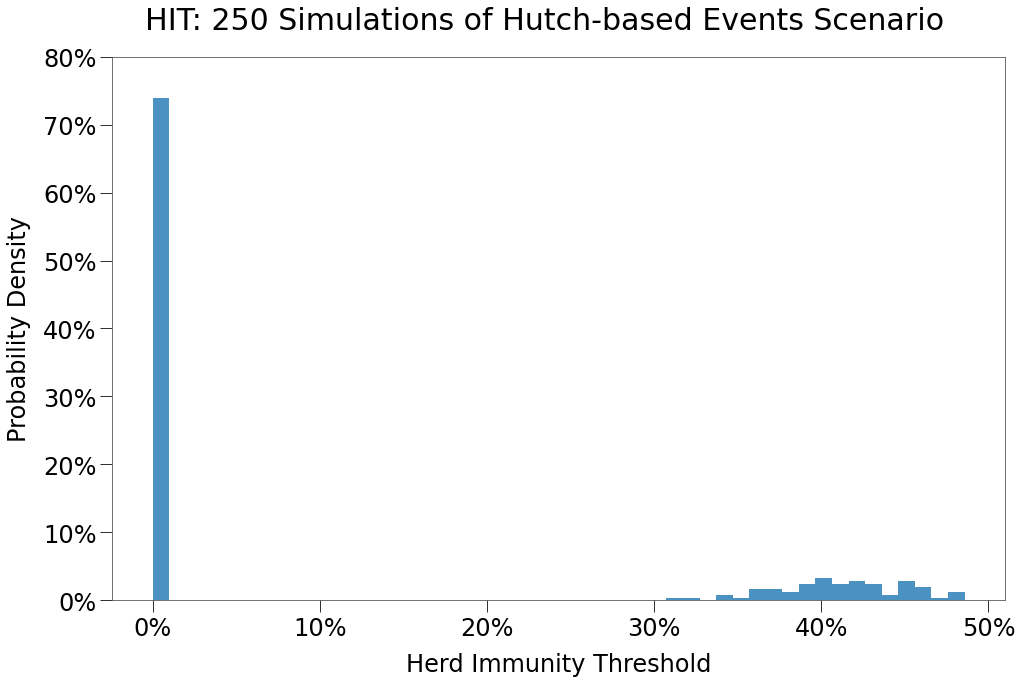

In [10]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/events_hist'

labels = [None]
title = r'HIT: 250 Simulations of Hutch-based Events Scenario'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

<img 
    src='https://storage.googleapis.com/rknotvids/us_w_load/events_hist.png'
    alt='Drawing' style='width: 700px;' align='center'
/>

#### 6. Gates ####
We can further improve the real world relevance of interactions by introducing [gates](concepts.ipynb#Gates). Subjects are not always freely able to interact with all other people in a population. Often their movement is restricted to within certain areas. Furthermore, other people's access into those areas is restricted.

Elderly people living in retirement homes or assisted living centers is an example. To simulate this, we will split `group4` into two separate groups. 

* `group4a`
    * population of 600 (2/3s of `group4`) 
    * IFR of 4.2%
    * move freely throughout the entire grid as previously
* `group4b` 
    * population of 300 (1/3rd of `group4`)
    * IFR of 7.8%
    * movement restricted to 6x6 box

We have also adjusted the IFR on the basis that `group4b` is likely older and also probably more frail than `group4a`. IFRs approximate those found [here](https://www.publichealthontario.ca/-/media/documents/ncov/epi/2020/06/covid19-epi-case-identification-age-only-template.pdf?la=en).

In addition, we will add an event specifically for the new group inside the gate.

```python
group4a = dict(
    name='70+',
    n=600,
    n_inf=0,
    ifr=0.042,
    mover='local',
)
group4b = dict(
    name='70+G',
    n=300,
    n_inf=0,
    ifr=0.0683,
    mover='local',
    box=[1,6,1,6],
    box_is_gated=True,
)
groups = [group1, group2, group3, group4a, group4b]

church2 = Event(
    name='church2', xy=[2,3], start_tick=7, 
    groups=[4], capacity=5, recurring=7
)

events_gated = [
    school1, school2, school3, game1, game2, game3, game4, 
    concert1, concert2, concert3, concert4, 
    bar1, bar2, bar3, bar4, bar5, 
    church, church2,
]
```

Now, such elderly populations are entirely sealed of from the rest of the world. In fact, they are often visited by family members or friends. We can mimick this with the use of a Travel object.

In this sim, at least one person will enter into the `group4b` gate for a day only. And this will repeat every day of the sim.

```python
from rknot.events import Travel

visit = Travel(
    name='visit', xy=[1,1], start_tick=3, 
    groups=[1,2], capacity=1, duration=1, recurring=1
)
events.append(visit)

sim = Sim(groups=groups, events=events, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [7]:
if IMPORT:
    from rknot import Sim, Chart
    from rknot.sims import us_w_load
    
    modulereload(us_w_load)
    assert 'susf' not in us_w_load.groups_gated[1]    
    assert all(g['mover'] == 'local' for g in us_w_load.groups)
    
if RUN:
    sim6 = Sim(groups=us_w_load.groups_gated, events=us_w_load.events_gated, **us_w_load.params)
    sim6.run()
    print (get_results(sim6))

(pid=80775) [Box([ 1, 50,  1, 50]), Box([1, 3, 1, 3])]
(pid=80775) [Box([ 1, 50,  1, 50]), Box([1, 3, 1, 3]), Box([25, 25, 42, 42]), Box([34, 34, 16, 16]), Box([47, 47, 28, 28]), Box([50, 50, 39, 39]), Box([24, 24, 25, 25]), Box([ 6,  6, 43, 43]), Box([26, 26, 49, 49]), Box([10, 10, 10, 10]), Box([45, 45, 46, 46]), Box([31, 31, 19, 19]), Box([19, 19, 21, 21]), Box([ 9,  9, 12, 12]), Box([43, 43,  9,  9]), Box([26, 26, 45, 45]), Box([ 8,  8, 14, 14]), Box([44, 44, 23, 23]), Box([ 2,  2, 46, 46]), Box([2, 2, 3, 3]), Box([1, 1, 1, 1])]



['38%', '56%', '71%', '0.44%', '33%', '0.62%', '63']


In [8]:
if SAVE:
    results = get_results(sim6)
    db['6'] = results

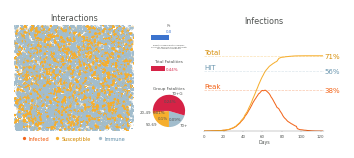

In [13]:
if SAVE_CHARTS:
    chart = Chart(sim6, **chart_params)
    chart.animate.save(
        PATH + '6.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/baseus/6.mp4' controls>Video Failed to Load</video>

In [9]:
md(results_table(*db['6']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   38% | 
| HIT      | 56%      | 
| Total      | 71%      | 
| Fatalities | 0.44%      | 
| % > 70 | 33%      | 
| IFR | 0.62%      | 
| Days to Peak |   63 | 


Again, the gated structure is intended to mimic [Example 1](#1.-Equal), [Example 3](#3.-Social), and [Example 5](#5.-Events).

The use for Events and Gates will become clear when we explore the impact of [Policy Decisions](#Policy).

#### 9. Self Aware Social Distancing + Pre-Immunity ####
In a self-aware population, we can also incorporate an assumption that certain members of the population will implement social distancing practices (even in the absence of prescribed government policy). For example, individuals might wear masks or face shields while in public. 

This is implemented via a SocialDistancing object, which reduces the transmission factor of the subjects in the applicable group.

```python
from rknot.events import SocialDistancing as SD

sd = SD(name='6-feet', tmfs=[.975,.95,.75,.5], groups=[1,2,3,4], start_tick=5, duration=90)
events.append(sd)

sim = Sim(groups=groups, events=events, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [14]:
if IMPORT:
    from rknot import Sim, Chart
    from rknot.sims import us_w_load
    modulereload(us_w_load)
    assert len(us_w_load.events_gated) == 19
    assert 'susf' not in us_w_load.groups_gated[1]

    from rknot.events import SocialDistancing as SD
    
    groups_gated = us_w_load.groups_gated
    events_gated = us_w_load.events_gated

    groups_gated[1]['susf'] = .8
    groups_gated[2]['susf'] = .65    

    sd = SD(name='6-feet', tmfs=[.975,.95,.75,.5], groups=[1,2,3,4], start_tick=5, duration=90)
    events_gated.append(sd)
if RUN:
    sim9 = Sim(groups=groups_gated, events=events_gated, **us_w_load.params)
    sim9.run()
    print (get_results(sim9))


['19%', '34%', '45%', '0.50%', '48%', '1.11%', '112']


In [38]:
if SAVE_CHARTS:
    chart = Chart(sim9, **chart_params)
    chart.animate.save(
        PATH + '9.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

In [39]:
if SAVE:
    results = get_results(sim9)
    db['9'] = results

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/baseus/9.mp4' controls>Video Failed to Load</video>

In [40]:
md(results_table(*db['9']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   14% | 
| HIT      | 36%      | 
| Total      | 60%      | 
| Fatalities | 0.33%      | 
| % > 70 | 27%      | 
| IFR | 0.55%      | 
| Days to Peak |   92 | 


Here we see that just the combination of pre-immunity and a modest amount of social distancing reduces all aspects of the infection curve.

Note that, despite the continued visits from outside, an outbreak in the 70+G group did *not* occur until *after* the social distancing practices were ceased. This outbreak resulted in a small surge in cases (visible in a rebound in the curve at ~100 days) and a tripling in fatalities in a short period.

So social distancing practices were helpful, but only so long as they were maintained.

### Policy ###

With a more realistic model of subject interaction, we can begin to experiment with the impact of different policy measures.

*RKnot* can simulate policy measures via `Restriction`, `SocialDistancing`, and `Quarantine` objects. Further details [here](concepts.ipynb#Restrictions).

The simulations are based on [this scenario](#6.-Gates) and so the impact of the policy measures contemplated should be considered relative to that scenario.

The structure can be imported as follows:

```python
from rknot.sims.baseus import params, events_gated, groups_gated
```

In [41]:
### HIDDEN ###
import matplotlib
matplotlib.use('Qt5Agg')

from matplotlib.animation import FFMpegWriter

from rknot import Sim, Chart

#### 1. Restrict Large Gatherings ####
We'll start by simply restricting large gathers, which for this sim is any event with 10+ capacity (0.1% of the entire population). The restrictions will last for 60 days.

When considering capacity, remember that a 100,000-seat stadium in a 10 million person catchment represents 1% of the population.

We assume this policy are implemented on day 30, when the population finally realizes there is a pandemic and government has had time to implement prevention measures.

The restriction will last for 60 days.

```python
from rknot.events import Restriction

large_gatherings = Restriction(
    name='large', start_tick=30, duration=60, criteria={'capacity': 10}
)
events_w_res = events_gated + [large_gatherings]

sim = Sim(groups=groups_gated, events=events_w_res, details=True, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [42]:
if IMPORT:
    from rknot.sims import baseus
    modulereload(baseus)
    assert len(baseus.events_gated) == 19
    assert 'susf' not in baseus.groups_gated[1]    
    
    from rknot.events import Restriction

    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    events_w_res = baseus.events_gated + [large_gatherings]
if RUN:
    sim10 = Sim(groups=baseus.groups_gated, events=events_w_res, **baseus.params)
    sim10.run()
    print (get_results(sim10))

In [43]:
if SAVE:
    results = get_results(sim10)
    db['large'] = results

In [44]:
if SAVE_CHARTS:
    chart = Chart(sim10, **chart_params)
    chart.animate.save(
        PATH + 'large.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/baseus/large.mp4' controls>Video Failed to Load</video>
    

In [45]:
md(results_table(*db['large']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   15% | 
| HIT      | 28%      | 
| Total      | 73%      | 
| Fatalities | 0.45%      | 
| % > 70 | 38%      | 
| IFR | 0.62%      | 
| Days to Peak |   69 | 


We see that the curve is flattened significantly during the restriction period. Infections have a much lower peak, BUT also a much longer tail (evident by the still high relatively high level of total infections).

This results as the event restriction is lifted, which leads to a slower rate of decline of the virus.

#### 2. Social Distancing ####
We can mimick the implementation of Social Distancing policies in certain settings via the `SocialDistancing` object. Mask wearing, hand sanitizing, and 6-foot perimeters all provide varying levels of protection.

It is hard to estimate the degree of protection from each, and even harder in combination. For instance, [this study](https://pubmed.ncbi.nlm.nih.gov/23498357/) found anywhere between a 1.1- and 55-fold reduction in exposure to influenza with varying mask designs.

So we provide `tmfs` here for illustration purposes only, attempting to catch all social distancing practices. We also provide different `tmfs` for the different age groups, meant to simulate adherence to policy.

The policy measure is implemented on day 30 and maintained for 120 days.

```python
from rknot.events import SocialDistancing as SD

sd = SD(
    name='all', tmfs=[.8,.8,.7,.65,.5], 
    groups=[0,1,2,3,4], start_tick=30, duration=120
)
events_w_res = events_gated + [sd]

sim = Sim(groups=groups_gated, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [46]:
if IMPORT:
    from rknot.sims import baseus
    modulereload(baseus)
    assert len(baseus.events_gated) == 19
    assert 'susf' not in baseus.groups_gated[1]
if RUN:
    from rknot.events import SocialDistancing as SD

    sd = SD(name='all', tmfs=[.8,.8,.7,.65,.5], groups=[0,1,2,3,4], start_tick=30, duration=120)
    events_w_res = baseus.events_gated + [sd]

    sim11 = Sim(groups=baseus.groups_gated, events=events_w_res, **baseus.params)
    sim11.run()
    print (get_results(sim11))

In [47]:
if SAVE_CHARTS:
    chart = Chart(sim11, **chart_params)
    chart.animate.save(
        PATH + 'policy_sd.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

In [48]:
if SAVE:
    results = get_results(sim11)
    db['policy_sd'] = results

<video width='705' height='340'
       src='https://storage.googleapis.com/rknotvids/baseus/policy_sd.mp4' controls>Video Failed to Load</video>

In [49]:
md(results_table(*db['policy_sd']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   8% | 
| HIT      | 24%      | 
| Total      | 68%      | 
| Fatalities | 0.39%      | 
| % > 70 | 33%      | 
| IFR | 0.57%      | 
| Days to Peak |   96 | 


We can see that social distancing is certainly the most effective approach in terms of "flattening the curve" with the lowest HIT and peak infections seen thus far. 

The social distancing methods are successful in preventing an outbreak among the 70+G group until ~120 days, well after peak infections are reach.

However, consistent with the [restriction on large gatherings](#1.-Restrict-Large-Gatherings), the infection curve has protracted tail coinciding with the restriction being lifted. Over an extended time frame, the virus still infects a fairly large portion of the population.

#### 3. Restrict Elderly Visits ####
We can restrict events by name by passing `name` key to `criteria`. We can do this to restrict the travel event to the `70+G` area. 

The policy measure is implemented on day 30 and maintained for another 120 days. There will be no other restrictions.

```python
no_visits = Restriction(
    name='no_visits', start_tick=30, 
    duration=120, criteria={'name': 'visit'}
)
events_w_res = events_gated + [no_visits]

sim = Sim(groups=groups_gated, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [50]:
if IMPORT:
    from rknot.sims import baseus
    modulereload(baseus)
    assert len(baseus.events_gated) == 19
    assert 'susf' not in baseus.groups_gated[1]
if RUN:
    from rknot.events import Restriction    
    no_visits = Restriction(
        name='no_visits', start_tick=30, duration=120, criteria={'name': 'visit'}
    )
    events_w_res = baseus.events_gated + [no_visits]

    sim12 = Sim(groups=baseus.groups_gated, events=events_w_res, **baseus.params)
    sim12.run()
    print (get_results(sim12))

In [51]:
if SAVE:
    results = get_results(sim12)
    db['no_visits'] = results

In [52]:
if SAVE_CHARTS:
    chart = Chart(sim12, **chart_params)
    chart.animate.save(
        PATH + 'no_visits.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

<video width='705' height='340' 
    src='https://storage.googleapis.com/rknotvids/baseus/no_visits.mp4' controls>Video Failed to Load</video>

In [53]:
md(results_table(*db['no_visits']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   27% | 
| HIT      | 54%      | 
| Total      | 80%      | 
| Fatalities | 0.29%      | 
| % > 70 | 17%      | 
| IFR | 0.36%      | 
| Days to Peak |   77 | 


By simply quarantining the elderly, we see the most dramatic reduction in fatalities of any scenario thus far. An outbreak NEVER occurs in the 70+G gated area, even AFTER the policy restrictions are lifted, because the virus has already been eradicated by that time. 

We can see here that allowing a *high level of infection* among the **least susceptible** has resulted in a *low level of fatalities* among the **most susceptible**.

This is a controversial approach and does have difficult ethical implications, but its power to reduce death cannot be ignored.

#### 4. Social Distancing and Restrict Elderly Visits and Large Gatherings ####
What happens if we combine the three approaches above?

```python
large_gatherings = Restriction(
    name='large', start_tick=30, duration=60, criteria={'capacity': 10}
)
no_visits = Restriction(
    name='no_visits', start_tick=30, 
    duration=120, criteria={'name': 'visit'}
)
sd = SD(
    name='all', tmfs=[.8,.8,.7,.65,.5], 
    groups=[0,1,2,3,4], start_tick=30, duration=120
)
events_w_res = events_gated + [large_gatherings, no_visits, sd]

sim = Sim(groups=groups_gated, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [54]:
if IMPORT:
    from rknot.sims import baseus
    modulereload(baseus)
    assert len(baseus.events_gated) == 19
    assert 'susf' not in baseus.groups_gated[1]
if RUN:
    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    no_visits = Restriction(
        name='no_visits', start_tick=30, duration=120, criteria={'name': 'visit'}
    )
    sd = SD(name='all', tmfs=[.8,.8,.7,.65,.5], groups=[0,1,2,3,4], start_tick=30, duration=120)
    events_w_res = baseus.events_gated + [large_gatherings, no_visits, sd]

    sim13 = Sim(groups=baseus.groups_gated, events=events_w_res, **baseus.params)
    sim13.run()
    print (get_results(sim13))

In [55]:
if SAVE:
    results = get_results(sim13)
    db['sd_large_no_visits'] = results

In [56]:
if SAVE_CHARTS:
    chart = Chart(sim13, **chart_params)
    chart.animate.save(
        PATH + 'sd_&_no_large_&_no_visits.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/baseus/sd_%26_no_large_%26_no_visits.mp4' controls>Video Failed to Load</video>

In [57]:
md(results_table(*db['sd_large_no_visits']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   24% | 
| HIT      | 55%      | 
| Total      | 82%      | 
| Fatalities | 0.42%      | 
| % > 70 | 36%      | 
| IFR | 0.51%      | 
| Days to Peak |   199 | 


Incredibly, the combination of restrictions leads to worse outcomes than any of the individual restrictions on their own.

While in place, the restrictions do tightly contain infections and signficantly delay the onset of the pandemic. But once they are lifted, the virus spreads unabated through a still highly susceptible population.

i.e. Not enough subjects have achieved immunity by the time the restrictions are lifted.

#### 5. Quarantine ####
We can even mimick the impact of quarantines via the Quarantine object.

Here we show the impact of a 30-day quarantine for all groups in the Sim. We include a restriction on visits to the elderly during the quarantine.

```python
from rknot.events import Quarantine

quarantine = Quarantine(
    name='all', start_tick=30, 
    groups=[0,1,2,3,4], duration=30
)
no_visits = Restriction(
    name='no_visits', start_tick=30, 
    duration=30, criteria={'name': 'visit'}
)

events_w_res = events_gated + [quarantine, no_visits]

sim = Sim(groups=groups_gated, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [58]:
if IMPORT:
    from rknot.sims import baseus
    modulereload(baseus)
    assert len(baseus.events_gated) == 19
    assert 'susf' not in baseus.groups_gated[1]
if RUN:
    from rknot.events import Quarantine

    quarantine = Quarantine(name='all', start_tick=30, groups=[0,1,2,3,4], duration=30)
    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=30, criteria={'name': 'visit'}
    )

    events_w_res = baseus.events_gated + [quarantine, no_visits]
    
    sim14 = Sim(groups=baseus.groups_gated, events=events_w_res, **baseus.params)
    sim14.run()
    print (get_results(sim14))

In [59]:
if SAVE:
    results = get_results(sim14)
    db['quarantine'] = results

In [60]:
if SAVE_CHARTS:
    chart = Chart(sim14, **chart_params)
    chart.animate.save(
        PATH + 'quarantine.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

<video width='705' height='340'
       src='https://storage.googleapis.com/rknotvids/baseus/quarantine.mp4' controls>Video Failed to Load</video>
       

In [61]:
md(results_table(*db['quarantine']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   1% | 
| HIT      | 1%      | 
| Total      | 1%      | 
| Fatalities | 0.00%      | 
| % > 70 | 0%      | 
| IFR | 0.00%      | 
| Days to Peak |   32 | 


The pandemic never materializes in this simulation. The quarantine eradicates the virus swiftly upon implementation. 

This is an interesting result. This obvioulsy did not occur in many places in the real world that took this approach. There are several possible reasons worth considering:

* Random Variation: if you run this simulation multiple times, you will note some sims where spread does occur.
* Scale: a larger simulation would increase the possibility that a very small number of subjects can continue to pass around the virus while it is muted in the broader population
* Adherence: real-world adherence to the implemented policies was much lower than this simulation suggests.
* Inconsistency: some areas implemented strict quarantines while others did not, and there was mixing among those populations.

#### 6. Quarantine with Adherence ####

We can investigate the impact of low adherence to quarantine requirements by setting the `adherence` property of the `Quarantine` object.

```python
from rknot.events import Quarantine

quarantine = Quarantine(
    name='all', start_tick=30, 
    groups=[0,1,2,3,4], duration=30
)
no_visits = Restriction(
    name='no_visits', start_tick=30, 
    duration=30, criteria={'name': 'visit'}
)

events_w_res = events_gated + [quarantine, no_visits]

sim = Sim(groups=groups_gated, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [62]:
if IMPORT:
    from rknot.sims import baseus
    modulereload(baseus)
    assert len(baseus.events_gated) == 19
    assert 'susf' not in baseus.groups_gated[1]
if RUN:
    from rknot.events import Quarantine

    quarantine = Quarantine(
        name='all', start_tick=30, groups=[0,1,2,3,4], duration=30, adherence=.9
    )
    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=30, criteria={'name': 'visit'}
    )

    events_w_res = baseus.events_gated + [quarantine, no_visits]
    
    sim15 = Sim(groups=baseus.groups_gated, events=events_w_res, **baseus.params)
    sim15.run()
    print (get_results(sim15))

In [63]:
if SAVE:
    results = get_results(sim15)
    db['quarantine_w_ad'] = results

In [64]:
if SAVE_CHARTS:
    chart = Chart(sim15, **chart_params)
    chart.animate.save(
        PATH + 'quarantine_w_ad.mp4', 
        writer=FFMpegWriter(metadata=meta, **writer_params), 
        **save_params
    )

<video width='705' height='295'
       src='https://storage.googleapis.com/rknotvids/baseus/quarantine_w_ad.mp4' controls>Video Failed to Load</video>

In [65]:
md(results_table(*db['quarantine_w_ad']))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   21% | 
| HIT      | 52%      | 
| Total      | 80%      | 
| Fatalities | 0.58%      | 
| % > 70 | 47%      | 
| IFR | 0.72%      | 
| Days to Peak |   79 | 


With just 10% of the population ignoring the quarantine requirements, the virus spreads almost as though there was no quarantine at all.

### A Fulsome Scenario ###

We'll now create a more fulsome scenario encompassing many of the factors discussed.

Adjustments to prior scenarios include:

* add additional group with `mover='social'` in the 20-49 cohort. this cohort also flaunts social distancing guidelines as so its tmf in the SD object is `1.25`
* add susceptibility factors for most groups
* more fine-tuned capacity restrictions that gradually allow larger events over time
* restrict visits to the elderly for a full year

```python
### GROUPS ###
group1 = dict(
    name='0-19',
    n=2700,
    n_inf=0,
    ifr=0.00003,
    mover='local',
)
group2a = dict(
    name='20-49L',
    n=3900,
    n_inf=1,
    ifr=0.0002,
    mover='local',
    susf=0.85,    
)
group2b = dict(
    name='20-49S',
    n=200,
    n_inf=1,
    ifr=0.0002,
    mover='social',
    susf=0.85,    
)
group3 = dict(
    name='50-69',
    n=2300,
    n_inf=1,
    ifr=0.005,
    susf=.7,
    mover='local',
)
group4a = dict(
    name='70+',
    n=600,
    n_inf=0,
    ifr=0.042,
    mover='local',
    susf=0.9,    
)
group4b = dict(
    name='70+G',
    n=300,
    n_inf=0,
    ifr=0.0683,
    mover='local',
    box=[1,6,1,6],
    box_is_gated=True,
)
groups = [group1, group2a, group2b, group3, group4a, group4b]
params = {'dlevel': 'med', 'Ro':2.5, 'days': 365, 'imndur': 365, 'infdur': 14}

### EVENTS ###
from rknot.events import Event, Travel

school1 = Event(name='school1', xy=[25,42], start_tick=2, groups=[0], capacity=10, recurring=2)
school2 = Event(name='school2', xy=[78,82], start_tick=3, groups=[0], capacity=10, recurring=2)
game = Event(name='game', xy=[50,84], start_tick=6, groups=[0,1,2,3], capacity=100, recurring=14)
concert1 = Event(name='concert1', xy=[20,20], start_tick=7, groups=[1,2], capacity=50, recurring=14)                 
concert2 = Event(name='concert2', xy=[91,92], start_tick=21, groups=[1,2], capacity=50, recurring=14)
bar = Event(name='bar', xy=[17,24], start_tick=4, groups=[1,2], capacity=5, recurring=7)
bar2 = Event(name='bar2', xy=[87,13], start_tick=5, groups=[1,2], capacity=5, recurring=7)
bar3 = Event(name='bar3', xy=[52,89], start_tick=6, groups=[1,2,3], capacity=5, recurring=7)
church = Event(name='church', xy=[2,91], start_tick=7, groups=[3,4], capacity=20, recurring=7)
church2 = Event(name='church', xy=[2,3], start_tick=7, groups=[5], capacity=5, recurring=7)

visit = Travel(name='visit', xy=[1,1], start_tick=3, groups=[1,2,3], capacity=1, duration=1, recurring=1)

events = [
    school1, school2,
    game, concert1, concert2, bar, bar2, bar3, 
    church, church2, visit,
]

### RESTRICTIONS ###
small_gatherings = Restriction(
    name='small', start_tick=30, duration=30, criteria={'capacity': 5}
)
med_gatherings = Restriction(
    name='med', start_tick=60, duration=30, criteria={'capacity': 10}
)
large_gatherings = Restriction(
    name='large', start_tick=90, duration=30, criteria={'capacity': 50}
)
no_visits = Restriction(
    name='no_visits', start_tick=30, duration=365, criteria={'name': 'visit'}
)
sd = SD(name='all', tmfs=[.8, .8, 1.25, .7,.65,.5], groups=[0,1,2,3,4,5], start_tick=30, duration=120)
events_w_res = events + [small_gatherings, med_gatherings, large_gatherings, no_visits, sd]

sim = Sim(groups=groups, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [66]:
### HIDDEN ###
if RUN:
    ### GROUPS ###
    group1 = dict(
        name='0-19',
        n=2700,
        n_inf=0,
        ifr=0.00003,
        mover='local',
    )
    group2a = dict(
        name='20-49L',
        n=3900,
        n_inf=1,
        ifr=0.0002,
        mover='local',
        susf=0.85,    
    )
    group2b = dict(
        name='20-49S',
        n=200,
        n_inf=1,
        ifr=0.0002,
        mover='social',
        susf=0.85,    
    )
    group3 = dict(
        name='50-69',
        n=2300,
        n_inf=1,
        ifr=0.005,
        susf=.7,
        mover='local',
    )
    group4a = dict(
        name='70+',
        n=600,
        n_inf=0,
        ifr=0.042,
        mover='local',
        susf=0.9,    
    )
    group4b = dict(
        name='70+G',
        n=300,
        n_inf=0,
        ifr=0.0683,
        mover='local',
        box=[1,6,1,6],
        box_is_gated=True,
    )
    groups = [group1, group2a, group2b, group3, group4a, group4b]
    params = {'dlevel': 'med', 'Ro':2.5, 'days': 365, 'imndur': 365, 'infdur': 14}

    ### EVENTS ###
    from rknot.events import Event, Travelx

    school1 = Event(name='school1', xy=[25,42], start_tick=2, groups=[0], capacity=10, recurring=2)
    school2 = Event(name='school2', xy=[78,82], start_tick=3, groups=[0], capacity=10, recurring=2)
    game = Event(name='game', xy=[50,84], start_tick=6, groups=[0,1,2,3], capacity=100, recurring=14)
    concert1 = Event(name='concert1', xy=[20,20], start_tick=7, groups=[1,2], capacity=50, recurring=14)                 
    concert2 = Event(name='concert2', xy=[91,92], start_tick=21, groups=[1,2], capacity=50, recurring=14)
    bar = Event(name='bar', xy=[17,24], start_tick=4, groups=[1,2], capacity=5, recurring=7)
    bar2 = Event(name='bar2', xy=[87,13], start_tick=5, groups=[1,2], capacity=5, recurring=7)
    bar3 = Event(name='bar3', xy=[52,89], start_tick=6, groups=[1,2,3], capacity=5, recurring=7)
    church = Event(name='church', xy=[2,91], start_tick=7, groups=[3,4], capacity=20, recurring=7)
    church2 = Event(name='church', xy=[2,3], start_tick=7, groups=[5], capacity=5, recurring=7)

    visit = Travel(name='visit', xy=[1,1], start_tick=3, groups=[1,2,3], capacity=1, duration=1, recurring=1)

    events = [
        school1, school2,
        game, concert1, concert2, bar, bar2, bar3, 
        church, church2, visit,
    ]

    ### RESTRICTIONS ###
    small_gatherings = Restriction(
        name='small', start_tick=30, duration=30, criteria={'capacity': 5}
    )
    med_gatherings = Restriction(
        name='med', start_tick=60, duration=30, criteria={'capacity': 10}
    )
    large_gatherings = Restriction(
        name='large', start_tick=90, duration=30, criteria={'capacity': 50}
    )
    no_visits = Restriction(
        name='no_visits', start_tick=30, duration=120, criteria={'name': 'visit'}
    )
    sd = SD(name='all', tmfs=[.8, .8, 1.25, .7,.65,.5], groups=[0,1,2,3,4,5], start_tick=30, duration=120)
    events_w_res = events + [small_gatherings, med_gatherings, large_gatherings, no_visits, sd]

    sim15 = Sim(groups=groups, events=events_w_res, **params)
    sim15.run()


if SAVE_CHARTS:
    chart = Chart(sim15, **params)
    chart.animate.save(PATH + 'fulsome.mp4', writer=FFMpegWriter(fps=10))

In [67]:
if SAVE:
    results = get_results(sim)
    db['ful'] = results

<video width='705' height='340'
       src='https://storage.googleapis.com/rknotvids/baseus/fulsome.mp4' controls>Video Failed to Load</video>

In [69]:
# md(results_table(*db['ful']))

The virus barely survives for the first 6-months of the outbreak, then as per other scenarios, once restrictions are lifted an outbreak occurs. Still, when the outbreak does occur, it is characterized by one of the lowest peaks and HITs in our analysis (due in part to the pre-immmunity of some of the groups).

And it achieves the lowest fatality rate of the group, mainly by restricting access to the elderly population for the duration of the pandemic and ensuring an outbreak never occurs in that region.

In [11]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [12]:
move_to_doc_folder()

NameError: name 'move_to_doc_folder' is not defined